In [1]:
"""
follow up for 44a/b
use saved trained model

Shaina Lu
Gillis & Zador Labs
May 2021
"""

'\nfollow up for 44a/b\n\nShaina Lu\nGillis & Zador Labs\nMay 2021\n'

In [98]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
import random
from joblib import dump, load
from sklearn.metrics import roc_auc_score

In [14]:
#function for matplotlib formatting
def set_style():
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

In [3]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"

Pre-processing functions

In [7]:
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox

In [9]:
def makeyvector(mod_propont):
    """collapse propont into 1D y label vector"""
    newpropont = pd.DataFrame(columns=mod_propont.columns)
    for i in range(mod_propont.shape[1]):
        currcol = mod_propont.iloc[:,i]
        currcol.loc[currcol>0] = int(mod_propont.columns[i])
        newpropont[mod_propont.columns[i]] = currcol
        
    collapsedy = newpropont.sum(axis=1)

    return newpropont, collapsedy

In [10]:
#read in data
ontology = read_ontology()
STspotsmeta, STspots, STpropont = read_STdata()
#pre-processing
STpropont = filterproponto(STpropont)
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
STpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
STspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves

#collapse propont to 1D y vector
newpropont, collapsedy = makeyvector(STpropont)

number of leaf areas: 461


__predict using saved model__

In [5]:
#model 
model = load("OVR2STmod.joblib")

In [6]:
model

OneVsRestClassifier(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                               n_jobs=None, normalize=False),
                    n_jobs=None)

In [12]:
mod_data = STspots
#split train test for X data and y labels
#split data function is seeded so all will split the same way
Xtrain, Xtest, ytrain, ytest = train_test_split(mod_data, collapsedy, test_size=0.5,\
                                                random_state=42, shuffle=True,\
                                                stratify=collapsedy)
#z-score train and test folds
zXtrain = zscore(Xtrain)
zXtest = zscore(Xtest)

#predict
print(model)
trainpredictions = model.predict(zXtrain)
testpredictions = model.predict(zXtest)

OneVsRestClassifier(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                               n_jobs=None, normalize=False),
                    n_jobs=None)


In [68]:
trainpredictions

array([  945.,   962.,   962., ..., 10703.,   276.,   844.])

In [72]:
#print(np.unique(trainpredictions))
print(np.unique(testpredictions))

[ 430.  601. 1047.]


In [97]:
def predvectortomatrix(predvector, mod_propont):
    """break predictions vector out into matrix where ncols = nareas"""
    predmatrix = pd.DataFrame(0, index=(range(len(predvector))), columns = mod_propont.columns)
    for i in range(len(predmatrix.columns)):
        area = predmatrix.columns[i]
        for j in range(len(predvector)):
            if int(predvector[j]) == int(area):
                predmatrix.iloc[j,i] = 1
                
    return predmatrix

def matrixtoauroc(predmatrix, ytrue):
    """calculate AUROC for each brain area"""
    aurocs = []
    
    for col in predmatrix.columns:
        #aurocs.append(analytical_auroc(sp.stats.mstats.rankdata(predmatrix.loc[:,col]),ytrue.loc[:,col]))
        aurocs.append(roc_auc_score(ytest2.loc[:,col], STtestpredmatrix.loc[:,col]))
        
    return aurocs

In [ ]:
STtrainpredmatrix = predvectortomatrix(trainpredictions, STpropont)
STtestpredmatrix = predvectortomatrix(testpredictions, STpropont)

In [44]:
STtestpredmatrix.sum().sum()

14142

In [40]:
mod_propont = STpropont
#to get propont split on the same indicies
null1, null2, ytrain2, ytest2 = train_test_split(mod_data, mod_propont, test_size=0.5,\
                                                random_state=42, shuffle=True,\
                                                stratify=collapsedy)

In [102]:
STtestaurocs = matrixtoauroc(STtestpredmatrix, ytest2)
STtrainaurocs = matrixtoauroc(STtrainpredmatrix, ytrain2)

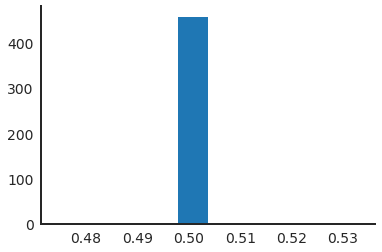

In [103]:
plt.hist(STtrainaurocs)
plt.show()

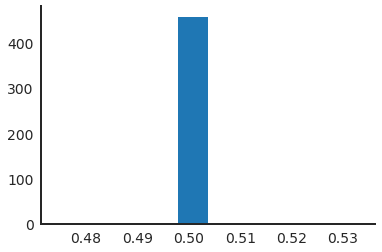

In [104]:
plt.hist(STtestaurocs)
plt.show()

In [64]:
#only 3 areas get predicted in train set, subset to look at those
STtestpred_sub = STtestpredmatrix.loc[:,STtestpredmatrix.sum() > 0]
STtrainpred_sub = STtrainpredmatrix.loc[:,STtrainpredmatrix.sum() > 0]

In [99]:
STtestaurocs = matrixtoauroc(STtestpred_sub, ytest2)
STtrainaurocs = matrixtoauroc(STtrainpred_sub, ytrain2)

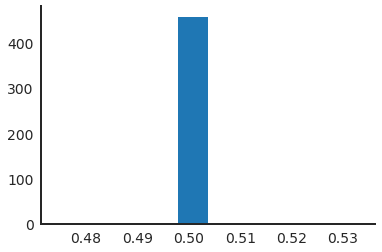

In [100]:
plt.hist(STtrainaurocs)
plt.show()

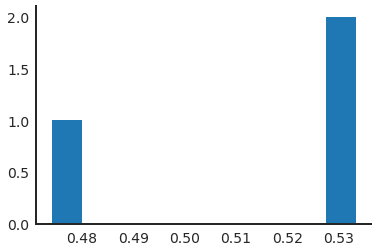

In [101]:
plt.hist(STtestaurocs)
plt.show()